## Домашнее задание №8

В данном задании вам предстоит детально рассмотреть механизм Attention (и реализовать несколько его вариантов), а также вернуться к задаче классификации текстов из задания №6 и решить ее с использованием BERT.

In [1]:
import os
import random

import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import clear_output 
%matplotlib inline

### Задание №1. Реализация Attention

В данной задаче вам предстоит реализовать механизм Attention, в частности несколько способов подсчета attention scores. Конечно, в популярных фреймворках данный механизм уже реализован, но для лучшего понимания вам предстаит реализовать его с помощью `numpy`.

Ваше задание в данной задаче: реализовать `additive` (аддитивный) и `multiplicative` (мультипликативный) варианты Attention. Для вашего удобства (и для примера) `dot product` attention (основанный на скалярном произведении) уже реализован.

Детальное описание данных типов Attention доступно в лекционных слайдах.

Text(0.5, 1.0, 'Decoder state')

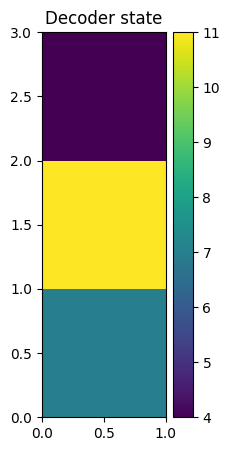

In [2]:
decoder_hidden_state = np.array([7, 11, 4]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(decoder_hidden_state)
plt.colorbar()
plt.title('Decoder state')

#### Dot product attention (пример реализации)
Рассмотрим единственное состояние энкодера – вектор с размерностью `(n_hidden, 1)`, где `n_hidden = 3` - размерность вектора, который генерирует единственное состояние энкодера:

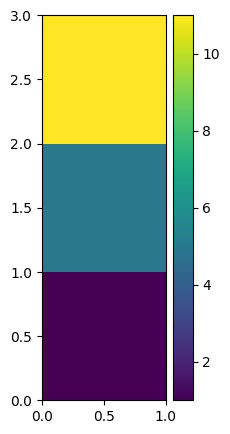

In [3]:
single_encoder_hidden_state = np.array([1, 5, 11]).astype(float)[:, None]

plt.figure(figsize=(2, 5))
plt.pcolormesh(single_encoder_hidden_state)
plt.colorbar()

Attention score между данными состояниями энкодера и декодера вычисляются просто как скалярное произведение:

In [4]:
np.dot(decoder_hidden_state.T, single_encoder_hidden_state)

array([[106.]])

В общем случае состояний энкодера, конечно, несколько. Attention scores вычисляются с каждым из состояний энкодера:

In [5]:
encoder_hidden_states = np.array([
    [1, 5, 11],
    [7, 4, 1],
    [8, 12, 2],
    [-9, 0, 1]
    
]).astype(float).T

encoder_hidden_states

array([[ 1.,  7.,  8., -9.],
       [ 5.,  4., 12.,  0.],
       [11.,  1.,  2.,  1.]])

Тогда для подсчета скалярных произведений между единственным состоянием декодера и всеми состояниями энкодера можно воспользоваться следующей функцией (которая по факту представляет собой просто матричное умножение и приведение типов):

In [6]:
def dot_product_attention_score(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)
    
    return: np.array of shape (1, n_states)
        Array with dot product attention scores
    '''
    attention_scores = np.dot(decoder_hidden_state.T, encoder_hidden_states)
    return attention_scores

In [7]:
dot_product_attention_score(decoder_hidden_state, encoder_hidden_states)

array([[106.,  97., 196., -59.]])

Для подсчета "весов" нам необходим Softmax:

In [8]:
def softmax(vector):
    '''
    vector: np.array of shape (n, m)
    
    return: np.array of shape (n, m)
        Matrix where softmax is computed for every row independently
    '''
    nice_vector = vector - vector.max() 
    exp_vector = np.exp(nice_vector)
    exp_denominator = np.sum(exp_vector, axis=1)[:, np.newaxis]
    softmax_ = exp_vector / exp_denominator
    return softmax_

**Замечание.**

Обратим внимание, что перед вычислением softmax мы выполняем некоторое преобразование:
$$nice\_vector=vector-max(vector)$$

Таким образом, у нас все значения в $nice\_vector$ будут неположительными.

Значит, операция экспоненты позволит получить вектор:

$$exp\_vector=e^{nice\_vector}=[x_1, ..., x_N]$$

При этом для любого $i\in[1, N]$ верно неравенство: 

$$0<=x_i<=1$$

Оно выполняется, т.к. экспонента в степени неположительного числа - это число из отрезка [0; 1].

Такое представление значительно лучше, чем возведение экспоненты в положительную степень, т.к. оно не генерирует очень больших чисел, которые могут вызвать массу ошибок округления, что приведет к некорректному вычислению softmax.

Теперь построим вектор весов для всех состояний:

In [9]:
weights_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))

weights_vector

array([[8.19401262e-040, 1.01122149e-043, 1.00000000e+000,
        1.79848622e-111]])

Наконец, воспользуемся данными весами и вычислим итоговый вектор, как и описано для dot product attention.

[[ 8.]
 [12.]
 [ 2.]]


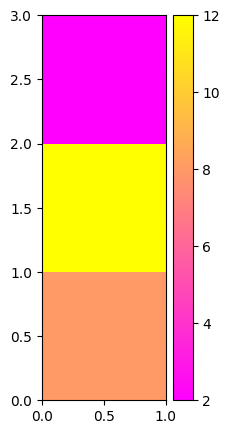

In [10]:
attention_vector = weights_vector.dot(encoder_hidden_states.T).T
print(attention_vector)

plt.figure(figsize=(2, 5))
plt.pcolormesh(attention_vector, cmap='spring')
plt.colorbar()

Данный вектор аккумулирует в себе информацию из всех состояний энкодера, взвешенную на основе близости к заданному состоянию декодера.

Реализуем все вышеописанные преобразования в единой функции:

In [11]:
def dot_product_attention(decoder_hidden_state, encoder_hidden_states):
    '''
    decoder_hidden_state: np.array of shape (n_features, 1)
    encoder_hidden_states: np.array of shape (n_features, n_states)
    
    return: np.array of shape (n_features, 1)
        Final attention vector
    '''
    softmax_vector = softmax(dot_product_attention_score(decoder_hidden_state, encoder_hidden_states))
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T
    return attention_vector

In [12]:
assert (attention_vector == dot_product_attention(decoder_hidden_state, encoder_hidden_states)).all()

#### Multiplicative attention
Ваша текущая задача: реализовать multiplicative attention.
$$ e_i = \mathbf{s}^TW_{mult}\mathbf{h}_i $$

Матрица весов `W_mult` задана ниже. 
Стоит заметить, что multiplicative attention позволяет работать с состояниями энкодера и декодера различных размерностей, поэтому состояния энкодера будут обновлены:

In [13]:
encoder_hidden_states_complex = np.array([
    [1, 5, 11, 4, -4],
    [7, 4, 1, 2, 2],
    [8, 12, 2, 11, 5],
    [-9, 0, 1, 8, 12]
    
]).astype(float).T

W_mult = np.array([
    [-0.78, -0.97, -1.09, -1.79,  0.24],
    [ 0.04, -0.27, -0.98, -0.49,  0.52],
    [ 1.08,  0.91, -0.99,  2.04, -0.15]
])

Реализуйте подсчет attention согласно формулам и реализуйте итоговую функцию `multiplicative_attention`:

In [14]:
def multiplicative_attention_score(decoder_hidden_state, encoder_hidden_states, W_mult):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    W_mult: np.array of shape (n_features_enc, n_features_dec)
    
    return: np.array of shape (1, n_states)
        Array with multiplicative attention scores
    '''
    intermediate_vector = np.dot(W_mult, encoder_hidden_states)
    attention_scores = np.dot(decoder_hidden_state.T, intermediate_vector)
    return attention_scores

def multiplicative_attention(decoder_hidden_state, encoder_hidden_states, W_mult):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    W_mult: np.array of shape (n_features_enc, n_features_dec)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    softmax_vector = softmax(multiplicative_attention_score(decoder_hidden_state, encoder_hidden_states, W_mult))
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T
    return attention_vector

#### Additive attention
Теперь вам предстоит реализовать additive attention.

$$ e_i = \mathbf{v}^T \text{tanh} (W_{add-enc} \mathbf{h}_i + W_{add-dec} \mathbf{s}) $$

Матрицы весов `W_add_enc` и `W_add_dec` доступны ниже, как и вектор весов `v_add`. Для вычисления активации можно воспользоваться `np.tanh`.

In [15]:
v_add = np.array([[-0.35, -0.58,  0.07,  1.39, -0.79, -1.78, -0.35]]).T

W_add_enc = np.array([
    [-1.34, -0.1 , -0.38,  0.12, -0.34],
    [-1.  ,  1.28,  0.49, -0.41, -0.32],
    [-0.39, -1.38,  1.26,  1.21,  0.15],
    [-0.18,  0.04,  1.36, -1.18, -0.53],
    [-0.23,  0.96,  1.02,  0.39, -1.26],
    [-1.27,  0.89, -0.85, -0.01, -1.19],
    [ 0.46, -0.12, -0.86, -0.93, -0.4 ]
])

W_add_dec = np.array([
    [-1.62, -0.02, -0.39],
    [ 0.43,  0.61, -0.23],
    [-1.5 , -0.43, -0.91],
    [-0.14,  0.03,  0.05],
    [ 0.85,  0.51,  0.63],
    [ 0.39, -0.42,  1.34],
    [-0.47, -0.31, -1.34]
])

Реализуйте подсчет attention согласно формулам и реализуйте итоговую функцию `additive_attention`:

In [16]:
def additive_attention_score(decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    v_add: np.array of shape (n_features_int, 1)
    W_add_enc: np.array of shape (n_features_int, n_features_enc)
    W_add_dec: np.array of shape (n_features_int, n_features_dec)
    
    return: np.array of shape (1, n_states)
        Array with additive attention scores
    '''
    enc_proj = np.dot(W_add_enc, encoder_hidden_states)
    dec_proj = np.dot(W_add_dec, decoder_hidden_state)
    sum_proj = enc_proj + dec_proj
    tanh_result = np.tanh(sum_proj)
    attention_scores = np.dot(v_add.T, tanh_result)
    return attention_scores

def additive_attention(decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec):
    '''
    decoder_hidden_state: np.array of shape (n_features_dec, 1)
    encoder_hidden_states: np.array of shape (n_features_enc, n_states)
    v_add: np.array of shape (n_features_int, 1)
    W_add_enc: np.array of shape (n_features_int, n_features_enc)
    W_add_dec: np.array of shape (n_features_int, n_features_dec)
    
    return: np.array of shape (n_features_enc, 1)
        Final attention vector
    '''
    softmax_vector = softmax(additive_attention_score(decoder_hidden_state, encoder_hidden_states, v_add, W_add_enc, W_add_dec))
    attention_vector = softmax_vector.dot(encoder_hidden_states.T).T
    return attention_vector


Сдайте функции `multiplicative_attention` и `additive_attention` в контест.

Не забудьте про импорт `numpy`!